<h1 style="text-align:center">Logistic Regression</h1> 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 1. Fit a regression model  For the binary classification (K=2)

The log-odds ratio is:

$$\log \frac{P}{1-P} = \beta_0 + \sum_{i=0}^p \beta_i^T x_i$$

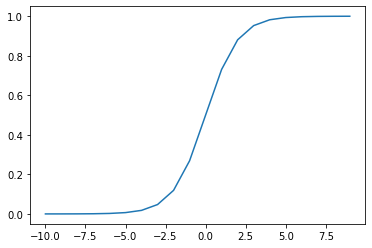

In [18]:
plt.plot(np.arange(-10,10), np.exp(np.arange(-10,10))/(1 + np.exp(np.arange(-10,10))))
#plt.plot(np.arange(-2,3), np.arange(-2,3))
#plt.ylim([-2,2])

Assume that the probability has the form as:

$$P(G = k|X=x) = \frac{\exp(\beta_{k0} + \sum_{i=1}^p \beta_{ki}^T x_{ki})}{1 + \exp(\beta_{k0} + \sum_{i=1}^p \beta_{ki}^T x_{ki})}$$

and then

$$1 - P(G = k|X=x) = \frac{1}{1 + \exp(\beta_{k0} + \sum_{i=1}^p \beta_{ki}^T x_{ki})}$$

Fit the logistic regression models by maximum (log-)likelihood, which is written as (Bernoulli distribution) :

$$\ell(\beta) = \sum_{i=1}^N \left( y_i \log p(x_i;\beta) + (1-y_i) \log (1-  p(x_i;\beta)) \right)$$

These score equations are:

$$\frac{\partial \ell (\beta)}{\partial \beta} = \sum_{i=1}^N x_i (y_i - p(x_i;\beta)) = 0$$

and second-derivatives are:

$$\frac{\partial^2 \ell (\beta)}{\partial \beta \partial \beta^T} = \sum_{i=1}^N x_i x_i^T p(x_i;\beta)(1 - p(x_i;\beta))$$

To solve the score equations, use the Newton-Raphson algorithm:

$$\beta^\text{new} = \beta^\text{old} - \left( \frac{\partial \ell (\beta)}{\partial \beta \partial \beta^T}  \right)^{-1}\frac{\partial \ell (\beta)}{\partial \beta}$$

### In matrix notation,

$$\frac{\partial \ell (\beta)}{\partial \beta} =  \mathbf{X}^T (\mathbf{y} - \mathbf{p})$$
$$\frac{\partial \ell (\beta)}{\partial \beta \partial \beta^T} =  - \mathbf{X}^T \mathbf{W} \mathbf{X}$$


$$\beta^\text{new} = \left( \mathbf{X}^T \mathbf{W} \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{W} \underbrace{\left( \mathbf{X}\beta^\text{old} + \mathbf{W}^{-1} (\mathbf{y} - \mathbf{p}) \right)}_{= \; \mathbf{z}}$$

This is referred to as iteratively reweighted least squares(IRLS) and it means that each steps is obtained by solving the weighted least squares:

$$\beta^\text{new} \leftarrow \mathrm{arg \; min}_\beta (\mathbf{z} - \mathbf{X}\beta)^T \mathbf{W} (\mathbf{z} - \mathbf{X}\beta)$$

- $\mathbf{y}$ : The vector of $y_i$
- $\mathbf{X}$ : $N \times (p+1)$ matrix of $x_i$
- $\mathbf{p}$ : The vector of fitted probabilities $p(x_i ; \beta^\text{old})$
- $\mathbf{W}$ : $N \times N$ diagonal matrix of $p(x_i ; \beta^\text{old})(1-p(x_i ; \beta^\text{old}))$
- $\mathbf{z} = \mathbf{X}\beta^\text{old} + \mathbf{W}^{-1} (\mathbf{y} - \mathbf{p})$ : The adjusted reponse

In [3]:
# Fit a Logistic regression model

def beta_new(X, beta0, y, step=100):
    beta = beta0
    p = find_p(X, beta)
    W = find_W(p)
    z = find_z(X, beta, W, y,p)
    
    for i in range(step):
 #       print(i)
        beta = find_beta_new(X,W,z)
        p = find_p(X, beta)
        W = find_W(p)
        z = find_z(X, beta, W, y,p)
        
    return beta
    
def find_beta_new(X,W,z):
    xwx = X.T * W * X 
    return  np.linalg.inv(xwx)*X.T*W* z 

def find_z(X, beta_old, W, y, p):
    return  X * beta_old + np.linalg.pinv(W) * (y - p)

def find_W(p):
    W = np.zeros((p.shape[0], p.shape[0]))
    for i in range(p.shape[0]):
        W[i,i] = p[i,0] * (1 - p[i,0])
    return W # NXN matrix

def find_p(X, beta_old):
    E = np.exp(X * beta_old)
    return E/(1+ E)    

def find_G(X, beta):
    p = find_p(X, beta)
    if p < 0.5:
        print("Class 2")
    elif p > 0.5:
        print("Class 1")
    else:
        print("on boundary")

## 2. Implementation for Example


- The number of data, $N = 100$
- The number of features, $p = 2$
- The number of classes, $K = 2$

$$y_i = 
\begin{cases}
1 \; ,& K = 1 \\ 0 \; ,& K = 2 
\end{cases}$$

then,

$$\begin{align}
p_1 &= Pr(G=1|X=x_i; \beta) \\
p_2 & = Pr(G=2|X=x_i; \beta) = 1 - p_1
\end{align}$$

In [4]:
np.random.seed(15)

x1 = np.random.normal(loc=0.8,scale=0.1,size=(40,2)) # class 1

x2_x = np.random.normal(1.2, 0.1, size=(60,1)) 
x2_y = np.random.normal(2.5, 0.2, size=(60,1))
x2 = np.column_stack([x2_x,x2_y]) # class 2

X = np.matrix(np.vstack((x1, x2)))
X_add_1 = sm.add_constant(X)
X_add_1.shape

(100, 3)

In [5]:
y1 = np.ones(40).reshape(40,1)
y2 = np.zeros(60).reshape(60,1)

y = np.matrix(np.vstack((y1, y2)))

In [6]:
beta0 = np.matrix([0,0,0]).reshape(3,1)
beta0.shape

(3, 1)

In [7]:
p0 = find_p(X_add_1, beta0)

In [8]:
W0 = find_W(p0)

In [9]:
Z0 = find_z(X_add_1, beta0, W0, y, p0)

In [10]:
beta = beta_new(X_add_1, beta0, y,50)

### Test

In [11]:
new_x = np.matrix([1, 1, 1.5])

In [12]:
find_G(new_x, beta)

Class 2


### Plot

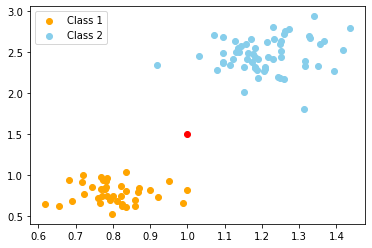

In [13]:
plt.scatter(x1[:,0], x1[:,1], color="orange", label="Class 1")
plt.scatter(x2[:,0], x2[:,1], color="skyblue", label="Class 2")
plt.scatter(new_x[0,1], new_x[0,2], color="red")

plt.legend()

In [14]:
domain_x = np.arange(0.6, 1.4, 0.01)
domain_y = np.arange(0.5, 3.0, 0.01)

### Decision Boundary

$$\ln{\frac{p}{1-p}} = \ln 1 = 0 = X \beta = \beta_0 + \beta_1 x_1 + \beta_2 x_2$$

In [15]:
def calc_boundary(xs, beta):
    return -1/beta[2,0] * (beta[1,0] * xs + beta[0,0])

Text(0, 0.5, '$X_2$')

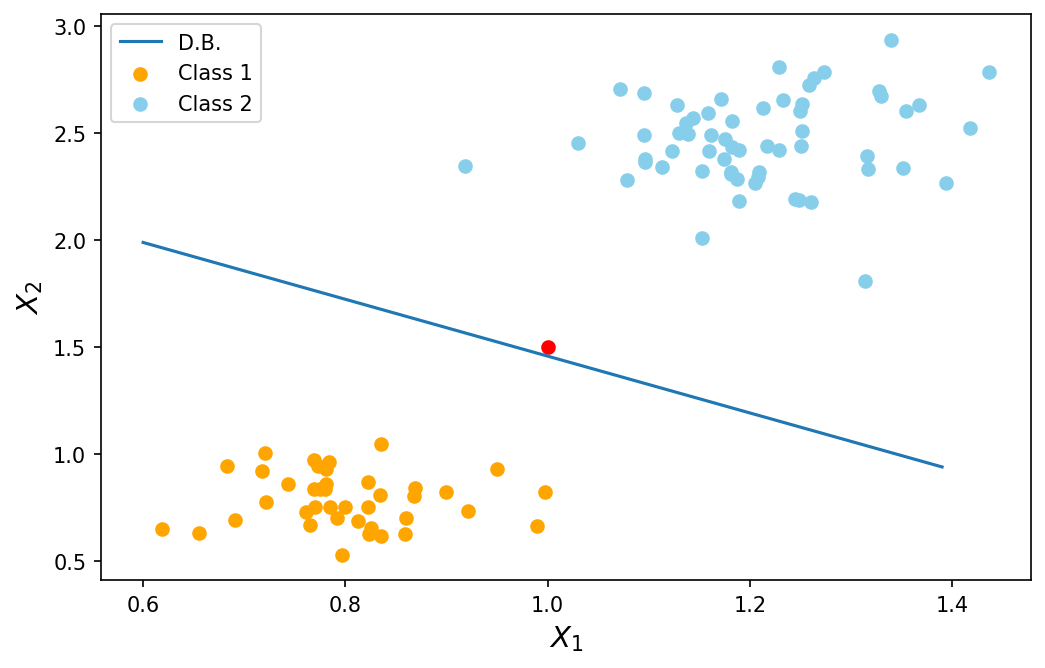

In [16]:
plt.figure(figsize=(8,5), dpi=150)

plt.plot(domain_x, calc_boundary(domain_x, beta), label="D.B.")
plt.scatter(x1[:,0], x1[:,1], color="orange", label="Class 1")
plt.scatter(x2[:,0], x2[:,1], color="skyblue", label="Class 2")
plt.scatter(new_x[0,1], new_x[0,2], color="red")

plt.legend()
plt.xlabel(r'$X_1$', fontsize=14)
plt.ylabel(r'$X_2$', fontsize=14)